# GeoBench BigEarthNetV2

In [4]:
import matplotlib.pyplot as plt
import json
from pathlib import Path
import numpy as np
import pandas as pd
import os

from geobench_v2.datamodules import GeoBenchBENV2DataModule
from geobench_v2.datasets.data_util import MultiModalNormalizer, SatMAENormalizer
from geobench_v2.datasets.visualization_util import compute_batch_histograms, plot_batch_histograms, plot_channel_histograms
import tacoreader
from geobench_v2.datasets.visualization_util import compute_batch_histograms, plot_batch_histograms
import torch
import numpy as np

In [2]:
band_order = {"s2": ["B04", "B03", "B02", 1.5], "s1": ["VV", "VH", 0.7]}

datamodule = GeoBenchBENV2DataModule(
    img_size=224,
    batch_size=16,
    num_workers=4,
    root="/mnt/rg_climate_benchmark/data/geobenchV2/benv2",
    band_order=band_order,
    data_normalizer=torch.nn.Identity(), # we do custom normalization in the tutorial
)
datamodule.setup("fit")

Error processing file /mnt/rg_climate_benchmark/data/geobenchV2/benv2/FullBenV2.0002.part.tortilla: File does not exist or unsupported protocol: /mnt/rg_climate_benchmark/data/geobenchV2/benv2/FullBenV2.0002.part.tortilla. Supported protocols: s3, gs, az, oss, swift, http, https, ftp, and hf.
Error processing file /mnt/rg_climate_benchmark/data/geobenchV2/benv2/FullBenV2.0001.part.tortilla: File does not exist or unsupported protocol: /mnt/rg_climate_benchmark/data/geobenchV2/benv2/FullBenV2.0001.part.tortilla. Supported protocols: s3, gs, az, oss, swift, http, https, ftp, and hf.
Error processing file /mnt/rg_climate_benchmark/data/geobenchV2/benv2/FullBenV2.0000.part.tortilla: File does not exist or unsupported protocol: /mnt/rg_climate_benchmark/data/geobenchV2/benv2/FullBenV2.0000.part.tortilla. Supported protocols: s3, gs, az, oss, swift, http, https, ftp, and hf.


ValueError: No objects to concatenate

In [ ]:
datamodule.visualize_geospatial_distribution()

AttributeError: 'GeoBenchBENV2DataModule' object has no attribute 'visualize_geospatial_distribution'

In [3]:
PROJECT_ROOT = Path("../../")
STATS_DIR = os.path.join(PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats")
STATS_WITH_CLIP_DIR = os.path.join(PROJECT_ROOT, "geobench_v2", "generate_benchmark", "dataset_stats_with_clip")

# Load dataset statistics from JSON files
direct_stats_path = os.path.join(STATS_DIR, "benv2", "benv2_stats.json")
satmae_stats_path = os.path.join(STATS_WITH_CLIP_DIR, "benv2", "benv2_stats.json")


def create_normalizer_from_stats(stats_path, normalizer_class, band_order):
    """Create a data normalizer from a stats JSON file."""
    with open(stats_path, 'r') as f:
        stats = json.load(f)
    
    means = {}
    stds = {}
    clip_min = {}
    clip_max = {}
    
    for modality, modality_stats in stats['input_stats'].items():
        mod_name = modality.split('_')[1]
        bands = modality_stats['band_names']
        mean_values = modality_stats['mean']
        std_values = modality_stats['std']

        if "clip_min_used" in modality_stats:
            clip_min[mod_name] = modality_stats['clip_min_used']
        if "clip_max_used" in modality_stats:
            clip_max[mod_name] = modality_stats['clip_max_used']
        
        for i, band in enumerate(bands):
            if i < len(mean_values) and i < len(std_values):
                means[band] = mean_values[i]
                stds[band] = std_values[i]
    
    norm_stats = {'means': means, 'stds': stds, 'clip_min': clip_min, 'clip_max': clip_max}
    
    # Create normalizer instance
    if normalizer_class == SatMAENormalizer:
        return normalizer_class(norm_stats, band_order, output_range="zero_one")
    else:
        return normalizer_class(norm_stats, band_order)  

multimodal_normalizer = create_normalizer_from_stats(direct_stats_path, MultiModalNormalizer, band_order)
satmae_normalizer = create_normalizer_from_stats(satmae_stats_path, SatMAENormalizer, band_order)

{'image_s2': tensor([587.1282, 612.2726, 434.7959,   0.0000]),
 'image_s1': tensor([2999.5278, 2988.1592,    0.0000])}

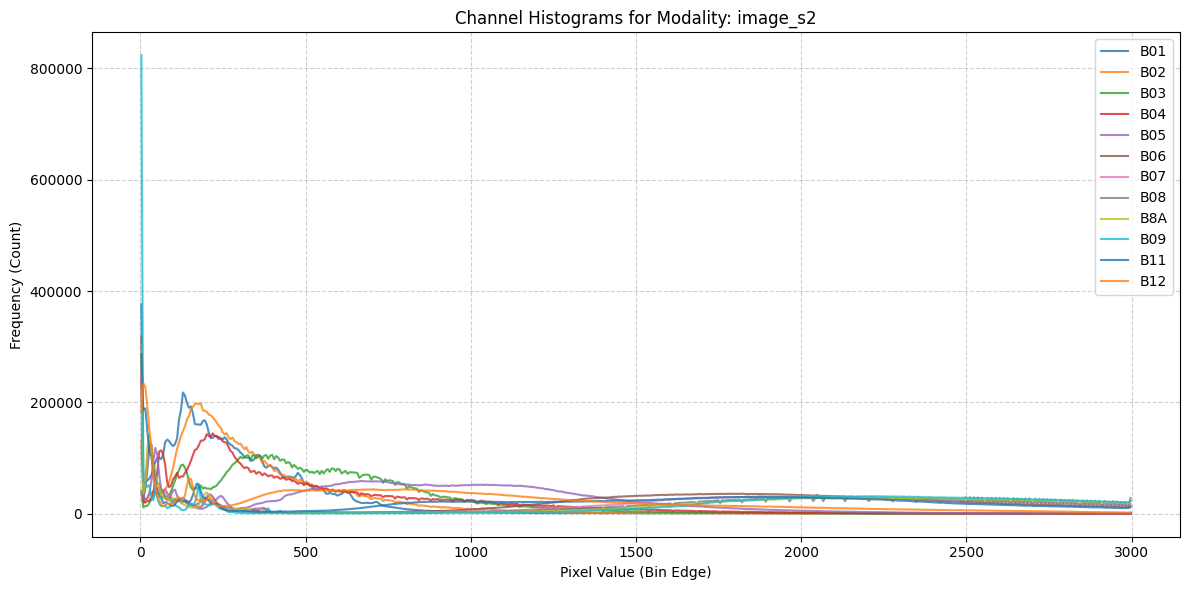

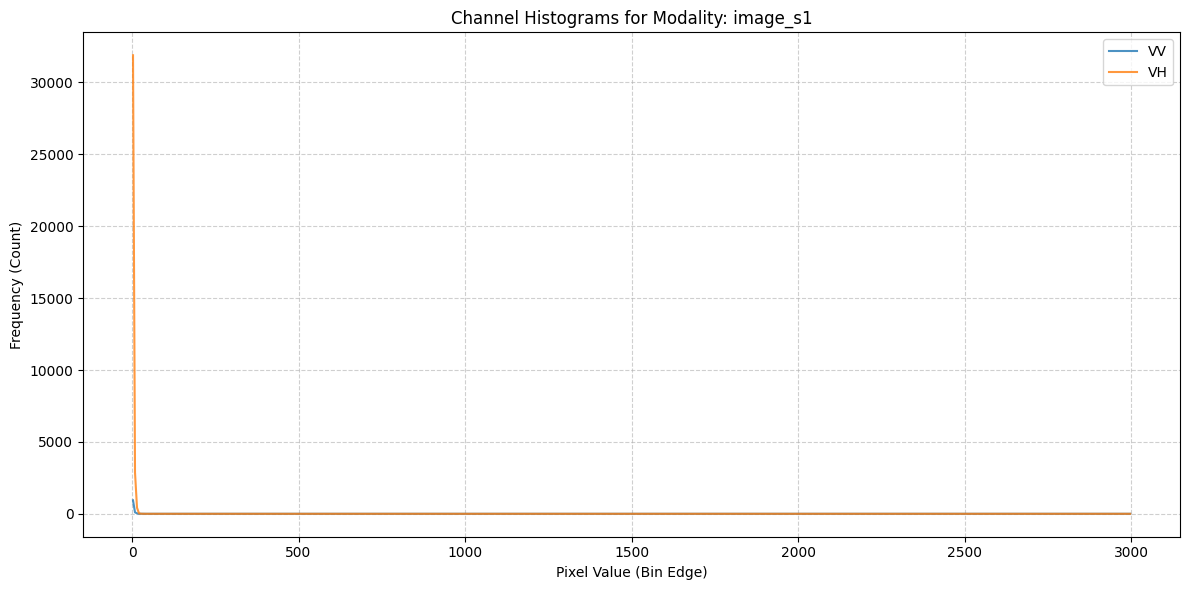

In [5]:
fig = plot_channel_histograms("/home/nils/projects/GEO-Bench-2/geobench_v2/generate_benchmark/dataset_stats/benv2/benv2_stats.json")

In [6]:
# Add this to cell with ID "68d50572"
# Get a batch of data from the dataloader
train_dataloader = datamodule.train_dataloader()
raw_batch = next(iter(train_dataloader))


# Compute histograms for the raw batch
raw_batch_stats = compute_batch_histograms(raw_batch, n_bins=100)

# Plot histograms for raw data
raw_figs = plot_batch_histograms(raw_batch_stats, band_order, title_suffix=" (Raw Data)")

# Display basic stats for the raw batch
print("Raw batch statistics:")
for modality, stats in raw_batch_stats.items():
    print(f"  {modality}:")
    for i, band_name in enumerate(band_order.get(modality, [])):
        if i < len(stats["mean"]):
            print(f"    {band_name}: mean={stats['mean'][i]:.2f}, std={stats['std'][i]:.2f}, min={stats['min'][i]:.2f}, max={stats['max'][i]:.2f}")

NameError: name 'datamodule' is not defined